Lendo a base de dados e importando recursos necessários

In [152]:
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin
import matplotlib.pyplot as plt

iris = load_iris()
X, y = iris.data[:,2:], iris.target

Cálculo da impureza

In [153]:
def impureza(y): #Gini
    labels = list(set(y))
    labels.sort()
    probabilidades = np.zeros((len(labels),))
    for i,k in enumerate(labels):
        probabilidades[i] = sum(y==k)/len(y)
    result = 1 - sum(probabilidades**2)
    return result

def impurezaValor(x, y, valor):
    maiores = x>valor
    impurezaMaiores = impureza(y[maiores])
    propMaiores = sum(maiores)/len(y)
    impurezaMenores = impureza(y[~maiores])
    propMenores = sum(~maiores)/len(y)
    impurezaTotal = propMaiores*impurezaMaiores + propMenores*impurezaMenores
    return impurezaTotal, impurezaMaiores, impurezaMenores     



Função para plotar o gráfico de decisão

In [154]:
def plotDecisao(modelo, X, y):
    modelo.fit(X, y)
    x0s = np.linspace(np.min(X[:,0])-0.2, np.max(X[:,0])+0.2, 100)
    x1s = np.linspace(np.min(X[:,1])-0.2, np.max(X[:,1])+0.2, 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    Xdec = np.c_[x0.ravel(), x1.ravel()]
    ypred = modelo.predict(Xdec)
    plt.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.25)
    for k in set(y):
        plt.plot(X[:,0][y==k], X[:,1][y==k], 'o', label=f"{iris.target_names[k]} [{k}]")
    plt.xlabel(f"X[0]: {iris.feature_names[0]}")
    plt.ylabel(f"X[1]: {iris.feature_names[1]}")
    plt.show()

Escolhendo a melhor característica - Versão Professor

In [155]:
def melhorValor(x, y):
    result = None
    menorImpureza = float('inf')
    xmax = np.max(x)
    xmin = np.min(x)
    while True:
        valor = (xmin+xmax)/2
        impTotal, impMaiores, impMenores = impurezaValor(x, y, valor)
        if impTotal < menorImpureza:
            menorImpureza = impTotal
            result = valor
            if impMaiores == 0 or impMenores == 0:
                break
            if impMaiores < impMenores:
                xmin = valor
            else:
                xmax = valor
        else:
            break
    return result, menorImpureza  

def melhorCaracteristica(X, y):
    impurezas = []
    valores = []
    for caracteristica in range(X.shape[1]):
        valor, imp = melhorValor(X[:,caracteristica], y)
        impurezas.append(imp)
        valores.append(valor)
    impurezas = np.array(impurezas)
    caracteristica = np.argmin(impurezas)
    return caracteristica, valores[caracteristica], impurezas[caracteristica]

Implementação do algoritmo Arvore de decisão do professor

In [156]:
def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]  

class Arvore(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.caracteristica, self.valor, self.imp = melhorCaracteristica(X,y)
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = Arvore()
            self.maiores.fit(X[maiores,:],y[maiores])
            self.menores = Arvore()
            self.menores.fit(X[~maiores,:],y[~maiores])
        else:
            self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y

Descobrindo a melhor característica com minha heurística.

In [157]:
import math as m
def melhorValorMeu(x, y):
    result = None
    menorImpureza = float('inf')
    xmax = np.max(x)
    xmin = np.min(x)
    while True:
        valor = 2/((1/xmin)+ (1/xmax))
        impTotal, impMaiores, impMenores = impurezaValor(x, y, valor)
        if impTotal < menorImpureza:
            menorImpureza = impTotal
            result = valor
            if impMaiores == 0 or impMenores == 0:
                break
            if impMaiores < impMenores:
                xmin = valor
            else:
                xmax = valor
        else:
            break
    return result, menorImpureza  

def melhorCaracteristicaMinha(X, y):
    impurezas = []
    valores = []
    for caracteristica in range(X.shape[1]):
        valor, imp = melhorValorMeu(X[:,caracteristica], y)
        impurezas.append(imp)
        valores.append(valor)
    impurezas = np.array(impurezas)
    caracteristica = np.argmin(impurezas)
    return caracteristica, valores[caracteristica], impurezas[caracteristica]

Adaptação da Arvore do professor para utilizar a minha seleção de melhor característica

In [158]:
class ArvoreMinha(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.caracteristica, self.valor, self.imp = melhorCaracteristicaMinha(X,y)
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = ArvoreMinha()
            self.maiores.fit(X[maiores,:],y[maiores])
            self.menores = ArvoreMinha()
            self.menores.fit(X[~maiores,:],y[~maiores])
        else:
            self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y

Descobrindo melhor característica com sklearn

In [159]:
from sklearn.tree import DecisionTreeClassifier

def melhorCaracteristicaSK(modeloSK):
    impurezas = np.array(modeloSK.feature_importances_)
    caracteristica = np.argmin(modeloSK.feature_importances_)
    return caracteristica,modeloSK.tree_.threshold[caracteristica], impurezas[caracteristica]

modeloSK = DecisionTreeClassifier(random_state=1)
modeloSK.fit(X, y)


DecisionTreeClassifier(random_state=1)

Comparando as três seleções de melhores características

In [160]:
print(f"Seleção Melhor característica professor: {melhorCaracteristica(X,y)}")
print(f"Seleção Melhor característica minha: {melhorCaracteristicaMinha(X,y)}")
print(f"Seleção Melhor característica sklearn: {melhorCaracteristicaSK(modeloSK)}")


Seleção Melhor característica professor: (0, 2.475, 0.3333333333333333)
Seleção Melhor característica minha: (0, 1.7468354430379747, 0.3529411764705883)
Seleção Melhor característica sklearn: (0, 0.800000011920929, 0.06492157918788351)


Comparando regiões de decisão

Professor


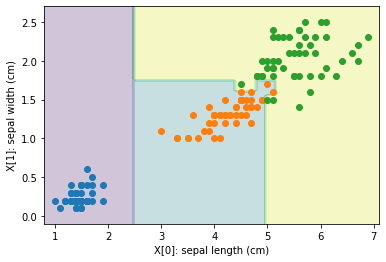

Meu


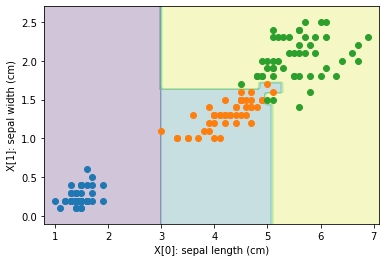

sklearn


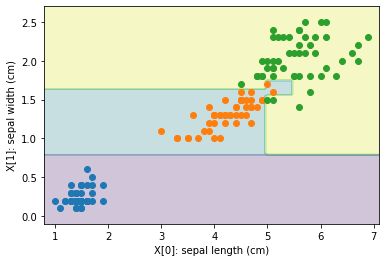

In [161]:
print("Professor")
plotDecisao(Arvore(), X, y)
print("Meu")
plotDecisao(ArvoreMinha(), X, y)
print("sklearn")
plotDecisao(modeloSK, X, y)

In [162]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, make_scorer, precision_score
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.datasets import load_wine, load_breast_cancer, load_digits
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import pandas as pd
def comparar_validacao_cruzada(X,y,nomeBase):  
    print("Análise para base: "+nomeBase)          
    scoring = {'accuracy': make_scorer(accuracy_score)}

    pipeline1 = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ("arvore", Arvore())
    ])

    scores1 = cross_validate(pipeline1, X, y,cv=10, scoring=scoring)

    print(f"Acurácia Professor: {np.mean(scores1['test_accuracy'])}")

    parametros = {}
                
    scoring = {'accuracy': make_scorer(accuracy_score)}

    pipeline2 = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),        
        ("arvoreM", ArvoreMinha())
    ])

    scores2 = cross_validate(pipeline2, X, y,cv=10, scoring=scoring)

    print(f"Acurácia Minha: {np.mean(scores2['test_accuracy'])}")

    parametros = {'dt__splitter': ['best','random'],
                'dt__max_depth':[1,3,5]}
                

    pipeline3 = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),        
        ("dt", DecisionTreeClassifier())
    ])

    modelo3 = GridSearchCV(pipeline3, parametros, scoring=scoring)

    scores3 = cross_validate(pipeline3, X, y,cv=10, scoring=scoring)

    print(f"Acurácia sklearn: {np.mean(scores3['test_accuracy'])}"+"\n\n")

wine = load_wine()
X1, y1 = wine.data[:,2:], wine.target

comparar_validacao_cruzada(X1, y1,'wine')

breast_cancer = load_breast_cancer()
X1, y1 = breast_cancer.data[:,2:], breast_cancer.target
comparar_validacao_cruzada(X1, y1,'breast_cancer')

digits = load_digits()
X1, y1 = digits.data[:,2:], digits.target
comparar_validacao_cruzada(X1, y1,'digits')



Análise para base: wine
Acurácia Professor: 0.8663398692810457
Acurácia Minha: 0.3993464052287582
Acurácia sklearn: 0.8996732026143791


Análise para base: breast_cancer
Acurácia Professor: 0.9103696741854638
Acurácia Minha: 0.6274122807017544
Acurácia sklearn: 0.9139097744360901


Análise para base: digits
Acurácia Professor: 0.8118994413407821
Acurácia Minha: 0.10128491620111732
Acurácia sklearn: 0.8224860335195532




Interpretação dos Resultados:
A primeira coisa que se percebe com os resultados é o fato de que a decisão de fazer as divisões dos nós afeta bastante a precisão de uma árvore. Isso fica evidente quando alterei a heurística do professor que fazia uma média aritmética, para uma média harmônica. Essa alteração influenciou diretamente na hora de calcular o melhor valor,  realizar as divisões e se chegar nas regiões de decisão, afetando diretamente a acurácia. Para manter maior coerência na comparação mantive para todos  a utilização do índice de Gine. 

